# Work With Time Series File For ESSP4
There is one time series file for each data set of the form: `DS#_timeSeries.csv`

For example, the relevant file for data set three (3) would be: `DS3_timeSeries.csv`

In [31]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import errorbar

In [32]:
# Specify file name

# Specify where all the data set folders (i.e. DS1) are, here saved into "essp_dir" variable
essp_dir = "/work2/lbuc/data/ESSP4/ESSP4"

# Specify data set number
dset_num = 1

example_file = os.path.join(essp_dir,f'DS{dset_num}',f'DS{dset_num}_timeSeries.csv')

In [33]:
# All data sets together

# Create a list to collect all dataframes
df_list = []

# Loop over dataset numbers 1 to 9
for dset_num in range(1, 10):
    file_path = os.path.join(essp_dir, f'DS{dset_num}', f'DS{dset_num}_timeSeries.csv')
    if os.path.exists(file_path):
        df_tmp = pd.read_csv(file_path)
        df_tmp["Dataset"] = f"DS{dset_num}"

        # Convert FWHM from km/s → m/s
        if "CCF FWHM [km/s]" in df_tmp.columns:
            df_tmp["CCF FWHM [m/s]"] = df_tmp["CCF FWHM [km/s]"] * 1000.0
            # optionally drop the old km/s column:
            df_tmp = df_tmp.drop(columns=["CCF FWHM [km/s]"])
        
        if "CCF FWHM Err. [km/s]" in df_tmp.columns:
            df_tmp["CCF FWHM Err. [m/s]"] = df_tmp["CCF FWHM Err. [km/s]"] * 1000.0
            # optionally drop the old km/s column:
            df_tmp = df_tmp.drop(columns=["CCF FWHM Err. [km/s]"])

        df_list.append(df_tmp)
    else:
        print(f"Warning: file not found {file_path}")

# Combine into one big dataframe
df_all = pd.concat(df_list, ignore_index=True)

print(df_all.head())


         Standard File Name   Time [eMJD]   RV [m/s]  RV Err. [m/s]  \
0  DS1.001_spec_harpsn.fits  59337.993481   9.825036          0.103   
1  DS1.002_spec_harpsn.fits  59337.997242   9.733036          0.103   
2  DS1.003_spec_harpsn.fits  59338.004754  12.039036          0.103   
3  DS1.004_spec_expres.fits  59338.301795  10.673016          0.110   
4  DS1.005_spec_expres.fits  59338.304359  10.135016          0.110   

   Exp. Time [s]   Airmass  BERV [km/s] Instrument   CCF Contrast  \
0     300.000000  1.125065    -0.581131     harpsn -457837.489595   
1     300.000000  1.130287    -0.590573     harpsn -457800.591871   
2     300.000000  1.142726    -0.609293     harpsn -457678.316202   
3     185.271000  1.306683    -0.000004     expres -354050.782988   
4     185.887999  1.317263    -0.000004     expres -354268.748737   

   CCF Contrast Err.  BIS [m/s]  H-alpha Emission  CaII Emission Dataset  \
0         543.369488 -51.516667          0.173834       0.100046     DS1   
1     

## Create DS.dat files for running with PyORBIT

In [34]:
###### RV ######
# Output directory for .dat files
outdir = "/work2/lbuc/iara/GitHub/PyORBIT_examples/ESSP4/data"

# Loop over datasets
for ds, subdf in df_all.groupby("Dataset"):

    # Get instruments present in this dataset
    instruments = sorted(subdf["Instrument"].unique())
    instrument_map = {inst: i for i, inst in enumerate(instruments)}

    
    # Columns
    time = subdf["Time [eMJD]"].values
    rv = subdf["RV [m/s]"].values
    rv_err = subdf["RV Err. [m/s]"].values
    jitter_flag = np.zeros(len(subdf), dtype=int)        # all 0
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)    # all -1

    # Combine
    data = np.column_stack([time, rv, rv_err, jitter_flag, offset_flag, subset_flag])

    # Save to .dat file
    outfile = os.path.join(outdir, f"{ds}_RV.dat")
    np.savetxt(outfile, data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])


###### BIS and FWHM ######

# Empirical errors
bis_err_val = 0.95      # m/s
fwhm_err_val = 0.005    # km/s

# Loop over datasets
for ds, subdf in df_all.groupby("Dataset"):

    # Get instruments present in this dataset
    instruments = sorted(subdf["Instrument"].unique())
    instrument_map = {inst: i for i, inst in enumerate(instruments)}

    time = subdf["Time [eMJD]"].values
    
    # =====================
    # BIS
    # =====================
    bis = subdf["BIS [m/s]"].values
    bis_err = np.full(len(subdf), bis_err_val)   # constant error
    jitter_flag = np.zeros(len(subdf), dtype=int)
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)

    bis_data = np.column_stack([time, bis, bis_err, jitter_flag, offset_flag, subset_flag])
    bis_outfile = os.path.join(outdir, f"{ds}_BIS.dat")
    np.savetxt(bis_outfile, bis_data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])

    # =====================
    # FWHM
    # =====================
    fwhm = subdf["CCF FWHM [m/s]"].values
    fwhm_err = np.full(len(subdf), fwhm_err_val) # constant error
    jitter_flag = np.zeros(len(subdf), dtype=int)
    offset_flag = subdf["Instrument"].map(instrument_map).astype(int).values
    subset_flag = -1 * np.ones(len(subdf), dtype=int)

    fwhm_data = np.column_stack([time, fwhm, fwhm_err, jitter_flag, offset_flag, subset_flag])
    fwhm_outfile = os.path.join(outdir, f"{ds}_FWHM.dat")
    np.savetxt(fwhm_outfile, fwhm_data, fmt=["%.6f", "%.6f", "%.6f", "%d", "%d", "%d"])


## Read in with `pandas`

In [40]:
## Plot of stellar activity indicators (including RV) in one figure for all DS
## using df_all (with corrected FWHM in m/s) and save into Figures folder


# Directory to save figures
fig_dir = os.path.expanduser("/work2/lbuc/iara/GitHub/ESSP/Figures")
os.makedirs(fig_dir, exist_ok=True)

# Loop over datasets in df_all
for ds, df in df_all.groupby("Dataset"):

    fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

    plot_info = [
        ("RV [m/s]", "RV Err. [m/s]", "RV [m/s]"),
        ("CCF Contrast", 130, "CCF Contrast"),
        ("CCF FWHM [m/s]", 5.0, "CCF FWHM [m/s] - mean"),
        ("BIS [m/s]", 0.95, "BIS [m/s]"),
        ("H-alpha Emission", 0.001, "H-alpha"),
        ("CaII Emission", 0.003, "CaII Emission"),
    ]

    for ax, (col, yerr, ylabel) in zip(axes, plot_info):
        for inst, subdf in df.groupby("Instrument"):
            if isinstance(yerr, str):
                # case where yerr is a column name (like RV)
                ax.errorbar(
                    subdf["Time [eMJD]"],
                    subdf[col] - subdf[col].mean(),
                    yerr=subdf[yerr],
                    fmt=".",
                    label=inst,
                    alpha=0.8,
                )
            else:
                # case where yerr is a constant
                ax.errorbar(
                    subdf["Time [eMJD]"],
                    subdf[col] - subdf[col].mean(),
                    yerr=yerr,
                    fmt=".",
                    label=inst,
                    alpha=0.8,
                )
        ax.set_ylabel(ylabel)

    axes[-1].set_xlabel("Time [eMJD]")
    axes[0].legend(loc="best")

    # Add title with dataset name (DS1 ... DS9)
    fig.suptitle(ds, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save figure
    fig_path = os.path.join(fig_dir, f"{ds}_activity.png")
    plt.savefig(fig_path, dpi=150)
    plt.close(fig)

    print(f"Saved figure: {fig_path}")


Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS1_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS2_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS3_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS4_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS5_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS6_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS7_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS8_activity.png
Saved figure: /work2/lbuc/iara/GitHub/ESSP/Figures/DS9_activity.png


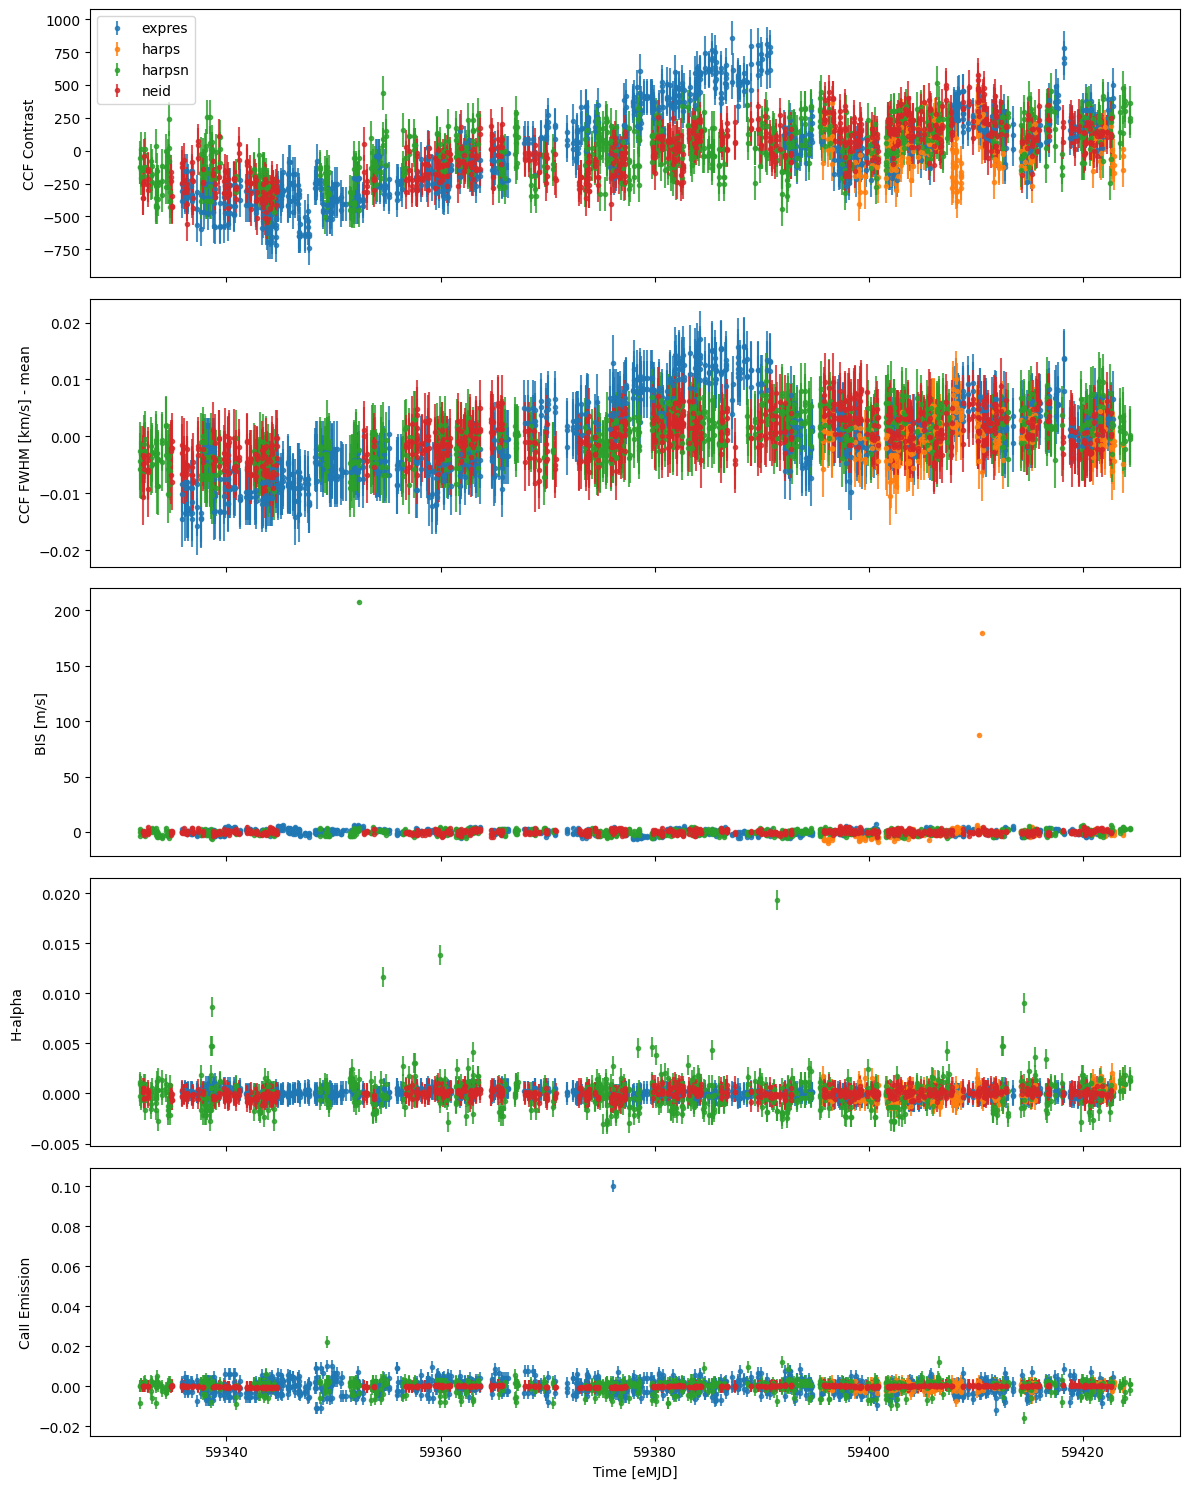

In [ ]:
## Plot of stellar activity indicators in one figure for all data frames

fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

plot_info = [
    ("CCF Contrast", 130, "CCF Contrast"),
    ("CCF FWHM [m/s]", 5.0, "CCF FWHM [m/s] - mean"),
    ("BIS [m/s]", 0.95, "BIS [m/s]"),
    ("H-alpha Emission", 0.001, "H-alpha"),
    ("CaII Emission", 0.003, "CaII Emission"),
]

for ax, (col, yerr, ylabel) in zip(axes, plot_info):
    for inst, subdf in df_all.groupby('Instrument'):
        ax.errorbar(
            subdf['Time [eMJD]'],
            subdf[col] - subdf[col].mean(),
            yerr=yerr,
            fmt='.',
            label=inst,
            alpha=0.8
        )
    ax.set_ylabel(ylabel)

axes[-1].set_xlabel("Time [eMJD]")
axes[0].legend(loc="best")

plt.tight_layout()
plt.show()

#### Plot RVs and Errors

<ErrorbarContainer object of 3 artists>

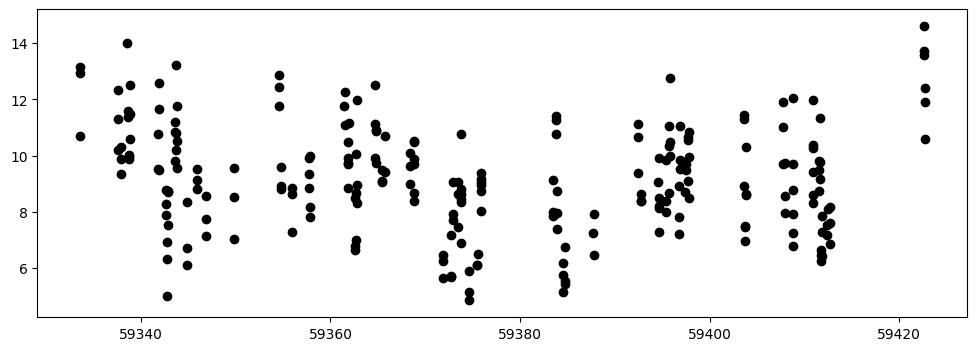

In [ ]:
plt.figure(figsize=(12,4))
plt.errorbar(df['Time [eMJD]'],df['RV [m/s]'],yerr=df['RV Err. [m/s]'],
             linestyle='None',marker='o',color='k')

## Rename Columns
I'm not crazy; I know the column names are unwieldy.  Here is code to re-name columns to those of your choosing using `pandas`.  New column names are defined using a dictionary that maps old names to new.  The dictionary does not need to include all column names.

In [ ]:
# Here are just some example new column names
# The key should be the original column name; the value should be the new name
col_dict = {
    'Standard File Name' : 'file',
    'Time [eMJD]' : 'time',
    'RV [m/s]' : 'rv',
    'RV Err. [m/s]' : 'e_rv',
    'Exp. Time [s]' : 'exptime',
    'Airmass' : 'airmass',
    'BERV [km/s]' : 'berv',
    'Instrument' : 'inst',
    'CCF FWHM [km/s]' : 'fwhm',
    'CCF FWHM Err. [km/s]' : 'e_fwhm',
    'CCF Contrast' : 'contrast',
    'CCF Contrast Err.' : 'e_contrast',
    'BIS [m/s]' : 'bis',
    'H-alpha Emission' : 'ha',
    'CaII Emission' : 'sval'
}

In [ ]:
df = pd.read_csv(example_file)
renamed_df = df.rename(columns=col_dict)
renamed_df.head()

,file,time,rv,e_rv,exptime,airmass,berv,inst,fwhm,e_fwhm,contrast,e_contrast,bis,ha,sval
0,DS1.001_spec_harpsn.fits,59337.993481,9.825036,0.103,300.000000,1.125065,-0.581131,harpsn,6.856194,0.012190,-457837.489595,543.369488,-51.516667,0.173834,0.100046
1,DS1.002_spec_harpsn.fits,59337.997242,9.733036,0.103,300.000000,1.130287,-0.590573,harpsn,6.857638,0.012348,-457800.591871,550.192273,-50.216667,0.172751,0.100664
2,DS1.003_spec_harpsn.fits,59338.004754,12.039036,0.103,300.000000,1.142726,-0.609293,harpsn,6.856079,0.012508,-457678.316202,557.232302,-49.500000,0.174994,0.107149
3,DS1.004_spec_expres.fits,59338.301795,10.673016,0.110,185.271000,1.306683,-0.000004,expres,6.692954,0.015302,-354050.782988,544.182192,-76.200000,0.172216,0.103057
4,DS1.005_spec_expres.fits,59338.304359,10.135016,0.110,185.887999,1.317263,-0.000004,expres,6.690432,0.015546,-354268.748737,553.370636,-73.850000,0.172323,0.100985


## Read Into Dictionary
If you don't like using `pandas` objects, I recommend using `pandas` to convert into a dictionary of lists.  The only annoying thing with this option is that each time series will be turned into a `list`, not a numpy array, and therefore will be missing some functionality.

Because of the structure of the CSV file and the mix of data types, it is pretty non-trivial to read the file in using `numpy` alone.

In [ ]:
df = pd.read_csv(example_file)
data_dict = df.to_dict('list')

<ErrorbarContainer object of 3 artists>

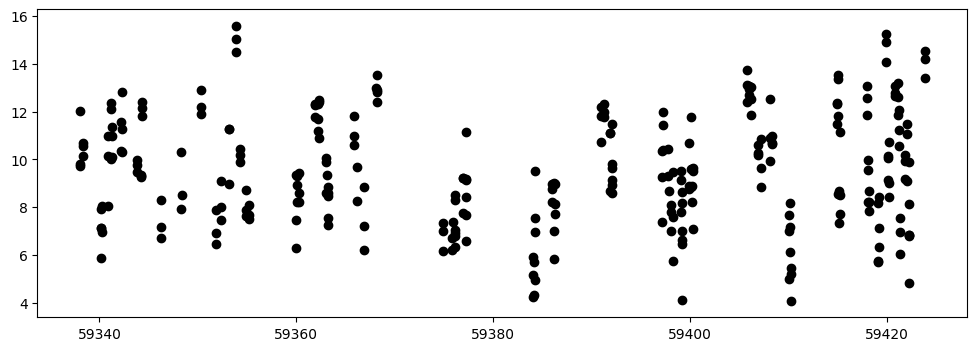

In [ ]:
plt.figure(figsize=(12,4))
plt.errorbar(df['Time [eMJD]'],df['RV [m/s]'],yerr=df['RV Err. [m/s]'],
             linestyle='None',marker='o',color='k')